In [1]:
from subprocess import check_output
import subprocess, random, json, matplotlib, os
from pandas import Series, DataFrame
from matplotlib import pyplot as plt 
import pandas as pd 
from time import time
%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
#q1 How many commits are there in the repo?

check_output(["git", "checkout", "master"], cwd="repo")

txt = check_output(["git", "log"], cwd="repo")
str_log = str(txt, "utf-8")
log_list = str_log.split("\n\n")

entries = 0 
for entry in log_list:
    if entry.startswith("commit"):
        entries +=1 
    else:
        continue
entries

8

In [3]:
#q2 How many commits were there by each author?
str_log.split("Author: ")
author_list = str_log.split("Author: ")[1:]
names = ["Ada", "Steve", "Linus"]
dic = {}

author_order = []
for name in names:
    dic[name] = 0
    for author in author_list:
        if name in author:
            author_order.append(name)
            dic[name] += 1 
        else:
            continue            
dic

{'Ada': 3, 'Steve': 3, 'Linus': 2}

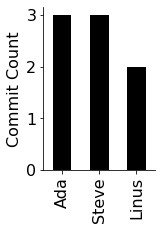

In [4]:
#q3 How many commits were there for each developer?
s = pd.Series(dic, index=dic.keys())
ax = s.plot(figsize=(2,3), kind="bar", color = "0")
ax.set_ylabel("Commit Count")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
None

In [6]:
#Creating a list with ever commit version in it 
git_log = check_output(["git", "log"], cwd="repo")
git_log_str = str(git_log)
git_log_str = git_log_str[2:]
commits = git_log_str.split("\\n")

all_lines = []
author_lines = []
commit_lines = []
date_lines = []
for line in commits:
    if line.startswith("Author"):
        author_lines.append(line)
        all_lines.append(line)
    elif "commit" in line:
        commit_lines.append(line)
        all_lines.append(line)
    elif line.startswith("Date"):
        date_lines.append(line)
        all_lines.append(line)
codes = []
for line in commit_lines:
    codes.append(line[7:])

In [7]:
#q4 How has the size of wc.py grown over time?
size_codes = []
for i in codes:
    check_output(["git", "checkout", i], cwd="repo")
    size_codes.append(int(str(check_output(["wc", "-l", "wc.py"], cwd = "repo"))[2:4]))
check_output(["git", "checkout", "master"], cwd="repo")
commits_list = size_codes[::-1]
commits_list

[21, 35, 35, 39, 40, 40, 40, 43]

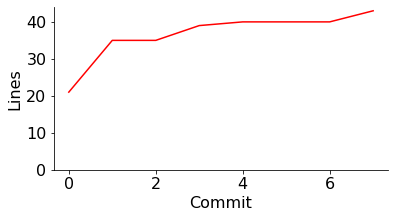

In [8]:
#q5 Visualize how the size of the code has grown over time
s = pd.Series(commits_list, index= range(len(commits_list)))
ax = s.plot(figsize=(6,3), kind="line", color = "red", ylim=0)
ax.set_ylabel("Lines")
ax.set_xlabel("Commit")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("sizeovertime.png")

In [13]:
#Dummy test string to run wc.py on
test1 = """X Y Z"""

test2 = """A B 
A C
"""
test3 = """A B 
a c
"""

In [14]:
#q6 Running run_wc on test1
def run_wc(body, commit=None):
    if commit == None:
        check_output(["git", "checkout", "master"], cwd="repo")
    else:
        check_output(["git", "checkout", str(commit)], cwd = "repo")
    test = os.path.join("repo", "test.txt")
    with open(test, "w", encoding = "utf-8") as file:
        file.write(body)
    try:
        output = check_output("python3 wc.py test.txt ALL", shell = True, cwd = "repo",  universal_newlines=True)
        json_answer = json.loads(output)
        check_output(["git", "checkout", "master"], cwd="repo")
        return json_answer 
    except subprocess.CalledProcessError:
        return None

run_wc(test1)

{'X': 1, 'Y': 1, 'Z': 1}

In [15]:
#q7 Running run_wc on test2
run_wc(test3)

{'A': 2, 'B': 1, 'C': 1}

In [16]:
#Function creates takes in a string as an argument and returns a df showing if a commit of wc.py ran matches what's expected for all commits  
def test_table(body, expected):
    
    commits = []
    for i in range(len(codes)):
        commits.append(codes[i])
    author_names = []
    for i in range(len(author_list)):
        for name in names:
            if name in author_list[i]:
                author_names.append(name)    
        
    pass_fail = []
    for i in range(len(codes)):
        try:
            output = run_wc(body,codes[i])
        except FileNotFoundError:
            print("program not installed?")
        except subprocess.CalledProcessError as e:
            print("program crashed")
            pass_fail.append("False")
            continue
        if output == expected:
            pass_fail.append("True")
        else:
            pass_fail.append("False")


    return DataFrame({"commit": commits[::-1], "author": author_names[::-1], "pass": pass_fail[::-1]})

In [19]:
#q8 Running test_table on test1
test_table(test1, {'X': 1, 'Y': 1, 'Z': 1})

,commit,author,pass
0,6d7beafb8e79b7a92fed8e67673a33bb7f607dbe,Ada,False
1,b0df6dbe111f9e28fc3a9c9b841cde5c20c365f9,Linus,True
2,761627a3ad9ee681f27211326e9149f01764ceee,Linus,True
3,6f5ca9327e986315ffcacddce5d9d6195c0913b7,Ada,True
4,f37e610ce055a3d894baac2d9449e6eb77c72320,Steve,True
5,c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5,Ada,True
6,f637df3f45bc389e1035cc3aadcf5d81a55f0dc4,Steve,False
7,4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4,Steve,True


In [20]:
#q9 Running test_table on test2
test_table(test2, {'A': 2, 'B': 1, 'C': 1})

,commit,author,pass
0,6d7beafb8e79b7a92fed8e67673a33bb7f607dbe,Ada,False
1,b0df6dbe111f9e28fc3a9c9b841cde5c20c365f9,Linus,False
2,761627a3ad9ee681f27211326e9149f01764ceee,Linus,True
3,6f5ca9327e986315ffcacddce5d9d6195c0913b7,Ada,True
4,f37e610ce055a3d894baac2d9449e6eb77c72320,Steve,True
5,c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5,Ada,True
6,f637df3f45bc389e1035cc3aadcf5d81a55f0dc4,Steve,False
7,4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4,Steve,True


In [21]:
#q10 Running test_table on test3
test_table(test3, {'A': 2, 'B': 1, 'C': 1})

,commit,author,pass
0,6d7beafb8e79b7a92fed8e67673a33bb7f607dbe,Ada,False
1,b0df6dbe111f9e28fc3a9c9b841cde5c20c365f9,Linus,False
2,761627a3ad9ee681f27211326e9149f01764ceee,Linus,False
3,6f5ca9327e986315ffcacddce5d9d6195c0913b7,Ada,True
4,f37e610ce055a3d894baac2d9449e6eb77c72320,Steve,True
5,c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5,Ada,True
6,f637df3f45bc389e1035cc3aadcf5d81a55f0dc4,Steve,False
7,4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4,Steve,True


In [24]:
#Versions to test performance of wc.py on
versions = {
    "v3-single-pass": "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4",
    "v2-pass-per-uniq": "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5",
    "v1-open-once": "f37e610ce055a3d894baac2d9449e6eb77c72320",
    "v0-baseline": "6f5ca9327e986315ffcacddce5d9d6195c0913b7",
}

In [25]:
#Returns the time taken for each version to run wc.py on x randomly sampled words from y total 
def time_run_sec(uniq_words, total_words, word_size=6, commit=None):
    word_list = [] 
    chars = ("a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","q","r","s","t","u","v","w","x","y","z")
    for i in range(uniq_words):
        word = ''.join(random.choices(chars, k = word_size))
        if word not in word_list:
            word_list.append(word)
        else:
            word = ''.join(random.choices(chars, k = word_size))
            word_list.append(word)
    s = ""
    for j in range(total_words):
        new = random.choice(word_list)
        s = s + " " + f"{new}"   
        
    t0 = time()
    run_wc(s, commit)        
    t1 = time()
    return (t1-t0)

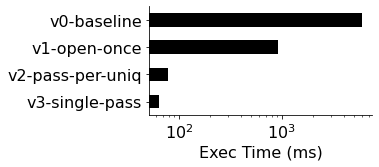

In [26]:
#q11 Running time_run_sec for 100 unique words of 5000 total words
df = {}
        
for version in versions:
    df[version] = (time_run_sec(100, 5000, commit = versions[version])) 
df
df = DataFrame(df.values(), index = df.keys())
df = df * 1e3
ax = df.plot(figsize=(4,2), kind="barh", color = "0", legend = False)
ax.set_xscale("log")
ax.set_xlabel("Exec Time (ms)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
None

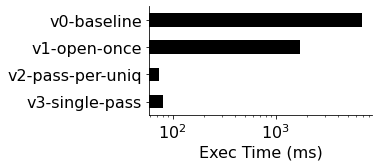

In [29]:
#q12 Running time_run_sec for 1 unique word of 5000 total words
df = {}
        
for version in versions:
    df[version] = (time_run_sec(1, 5000, commit = versions[version])) * 1e3
df = df 
df = DataFrame(df.values(), index = df.keys())
ax = df.plot(figsize=(4,2), kind="barh", color = "0", legend = False)
ax.set_xscale("log")
ax.set_xlabel("Exec Time (ms)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

None

In [30]:
#Creating a DF with total words and percent unique for two commits
df = DataFrame()

x = time_run_sec(100, 1000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5") 
y = time_run_sec(50, 1000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
z = time_run_sec(10, 1000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
df.loc[1000, "10"] = x
df.loc[1000, "5"] = y
df.loc[1000, "1"] = z

x = time_run_sec(200, 2000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5") 
y = time_run_sec(100, 2000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
z = time_run_sec(20, 2000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
df.loc[2000, "10"] = x
df.loc[2000, "5"] = y
df.loc[2000, "1"] = z

x = time_run_sec(500, 5000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5") 
y = time_run_sec(250, 5000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
z = time_run_sec(50, 5000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
df.loc[5000, "10"] = x
df.loc[5000, "5"] = y
df.loc[5000, "1"] = z

x = time_run_sec(1000, 10000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5") 
y = time_run_sec(500, 10000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
z = time_run_sec(100, 10000, commit = "c10b5a6cb4f06c96f6f221df2d5ec33af767d5c5")
df.loc[10000, "10"] = x
df.loc[10000, "5"] = y
df.loc[10000, "1"] = z

In [33]:

df2 = DataFrame()

x = time_run_sec(100, 1000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4") 
y = time_run_sec(50, 1000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
z = time_run_sec(10, 1000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
df2.loc[1000, "10"] = x
df2.loc[1000, "5"] = y
df2.loc[1000, "1"] = z

x = time_run_sec(200, 2000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4") 
y = time_run_sec(100, 2000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
z = time_run_sec(20, 2000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
df2.loc[2000, "10"] = x
df2.loc[2000, "5"] = y
df2.loc[2000, "1"] = z

x = time_run_sec(500, 5000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4") 
y = time_run_sec(250, 5000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
z = time_run_sec(50, 5000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
df2.loc[5000, "10"] = x
df2.loc[5000, "5"] = y
df2.loc[5000, "1"] = z

x = time_run_sec(1000, 10000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4") 
y = time_run_sec(500, 10000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
z = time_run_sec(100, 10000, commit = "4e4128313b8d5b5e5d04f2e8e585f64f7c5831a4")
df2.loc[10000, "10"] = x
df2.loc[10000, "5"] = y
df2.loc[10000, "1"] = z

df2 = df2.rename_axis("percent unique", axis ="columns")
df2 = df2.rename_axis("total words", axis ="rows")


In [35]:
df2

percent unique,10,5,1
total words,,,
1000,0.063393,0.059211,0.056919
2000,0.057963,0.057717,0.059164
5000,0.062598,0.060713,0.061307
10000,0.066648,0.066998,0.064483


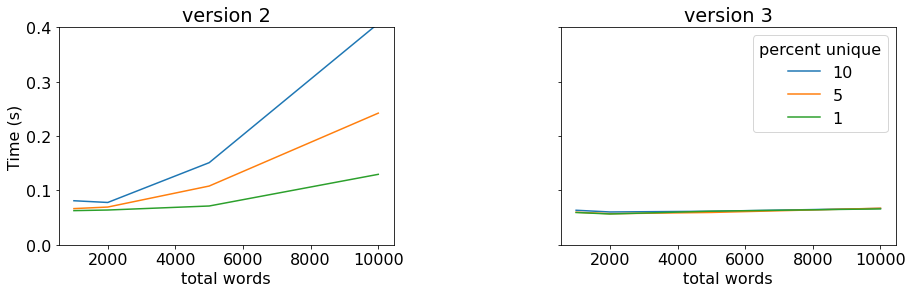

In [32]:
#q13
t = plt.subplots(ncols=2, figsize = (15,4), sharey=True)
ax_list = list(t[1])

df = df 
df2 = df2
ax = df.plot.line(ax=ax_list[0], legend=False)
ax.set_ylim(0,.4)
ax.set_xlabel("total words")
ax.set_ylabel("Time (s)")
ax.set_title("version 2")
ax = df2.plot.line(ax=ax_list[1])
ax.set_ylim(0,.4)
ax.set_xlabel("total words")
ax.set_title("version 3")

plt.subplots_adjust(wspace=.5)
